In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        # First Conv -> BN -> ReLu
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels) # normalization
        self.relu = nn.ReLU(inplace=True) # learn non-linearity

        # Second Conv -> BN (add padding=1 to preserve spatial size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        identity = x # Save input for the residual stuff

        out = self.conv1(x) 
        out = self.bn1(out)
        out = self.relu(out) 
        out = self.conv2(out)      
        out = self.bn2(out)        
        out = out + identity # Add skip connection
        out = self.relu(out) 

        return out


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # split output channels evenly across branches
        # each branch gets 0.25 of the channelse becasue there is 4 branches
        c = out_channels // 4 

        # 1×1 conv branch
        self.branch1 = nn.Conv2d(in_channels, c, kernel_size=1)

        # 3×3 conv branch
        self.branch3 = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)

        # 5×5 convn branch
        self.branch5 = nn.Conv2d(in_channels, c, kernel_size=5, padding=2)

        # Pooling branch (keeps spatial size)
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c, kernel_size=1)
        )

    def forward(self, x):
        # apply all branches in parallel
        # same image goes into all branches
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.branch_pool(x)

        # Concatenate along the channel dimension
        return torch.cat([b1, b3, b5, bp], dim=1)

class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super().__init__()

        # squeeze layer: 1×1 convolution (reduces channels)
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

        # expand in two paths 1×1 and 3×3 convolutions
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand3x3 = nn.Conv2d(
            squeeze_channels, expand_channels, kernel_size=3, padding=1
        )

    def forward(self, x):
        x = self.relu(self.squeeze(x)) # Squeeze step

        e1 = self.relu(self.expand1x1(x)) # Expand with 1×1
        e3 = self.relu(self.expand3x3(x)) # Expand with 3×3

        return torch.cat([e1, e3], dim=1) # Concatenate channels

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)

classes = trainset.classes

/home/coder/test/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [5]:
num_channels = 32 
# All models will use 2 conv-like blocks with num_channels channels, followed by global pooling and a 10-class linear layer.
# Baseline: Plain CNN
class PlainCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, num_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Small ResNet-like model
class SmallResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, num_channels, 3, padding=1)
        self.res1 = ResidualBlock(num_channels)
        self.res2 = ResidualBlock(num_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Small Inception-like model
class SmallInceptionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, num_channels, 3, padding=1)
        self.incept1 = InceptionBlock(num_channels, num_channels)
        self.incept2 = InceptionBlock(num_channels, num_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.incept1(x)
        x = self.incept2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Small SqueezeNet-like model
class SmallSqueezeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, num_channels, 3, padding=1)
        self.fire1 = FireModule(num_channels, 16, 16)
        self.fire2 = FireModule(num_channels, 16, 16)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.fire1(x)
        x = self.fire2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [6]:
# Improved SuperNet: Enhanced skip connections, normalization, and regularization
class SuperNet(nn.Module):
    def __init__(self):
        super().__init__()
        channels = 32
        self.stem = nn.Conv2d(3, channels, 3, padding=1)
        self.res1 = ResidualBlock(channels)
        self.incept = InceptionBlock(channels, channels)
        self.fire = FireModule(channels, 16, 16)
        self.bn = nn.BatchNorm2d(channels)
        self.res2 = ResidualBlock(channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(channels, 10)

    def forward(self, x):
        x = F.relu(self.stem(x))
        res = self.res1(x)
        out = self.incept(res)
        out = self.fire(out)
        out = self.bn(out)
        out = self.res2(out)
        out = out + res  # skip connection over the main path
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)


In [7]:
# Training and evaluation function for all models
def train_and_evaluate(model_class, name, device, trainloader, testloader, epochs=10):
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []
    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = correct / total
        train_loss = running_loss / total
        train_acc_hist.append(train_acc)
        train_loss_hist.append(train_loss)
        # Validation
        model.eval()
        correct, total, running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        val_acc = correct / total
        val_loss = running_loss / total
        val_acc_hist.append(val_acc)
        val_loss_hist.append(val_loss)
        print(f"{name} | Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    return train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist

In [8]:
# Train and evaluate all models
results = {}
for model_class, name in [
    (PlainCNN, 'PlainCNN'),
    (SmallResNet, 'ResNet-like model'),
    (SmallInceptionNet, 'Inception-like model'),
    (SmallSqueezeNet, 'SqueezeNet-like model'),
    (SuperNet, 'SuperNet')
]:
    print(f"\nTraining {name}...")
    train_acc, val_acc, train_loss, val_loss = train_and_evaluate(model_class, name, device, trainloader, testloader, epochs=10)
    results[name] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_loss': train_loss,
        'val_loss': val_loss
    }


Training PlainCNN...
PlainCNN | Epoch 1/10 - Train Acc: 0.2620, Val Acc: 0.3300
PlainCNN | Epoch 2/10 - Train Acc: 0.3428, Val Acc: 0.3738
PlainCNN | Epoch 3/10 - Train Acc: 0.3749, Val Acc: 0.3823
PlainCNN | Epoch 4/10 - Train Acc: 0.3920, Val Acc: 0.4028
PlainCNN | Epoch 5/10 - Train Acc: 0.4065, Val Acc: 0.4019
PlainCNN | Epoch 6/10 - Train Acc: 0.4164, Val Acc: 0.4105
PlainCNN | Epoch 7/10 - Train Acc: 0.4319, Val Acc: 0.4307
PlainCNN | Epoch 8/10 - Train Acc: 0.4410, Val Acc: 0.4444
PlainCNN | Epoch 9/10 - Train Acc: 0.4516, Val Acc: 0.4553
PlainCNN | Epoch 10/10 - Train Acc: 0.4611, Val Acc: 0.4663

Training ResNet-like model...
ResNet-like model | Epoch 1/10 - Train Acc: 0.4361, Val Acc: 0.4794
ResNet-like model | Epoch 2/10 - Train Acc: 0.5755, Val Acc: 0.5210
ResNet-like model | Epoch 3/10 - Train Acc: 0.6288, Val Acc: 0.6285
ResNet-like model | Epoch 4/10 - Train Acc: 0.6609, Val Acc: 0.5697
ResNet-like model | Epoch 5/10 - Train Acc: 0.6769, Val Acc: 0.6429
ResNet-like mode

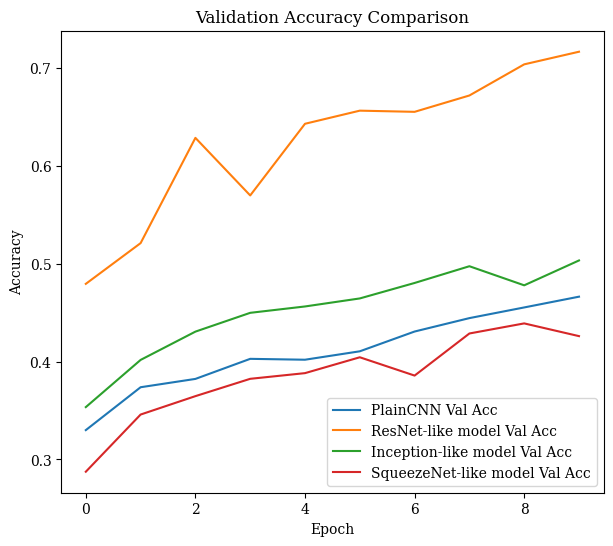

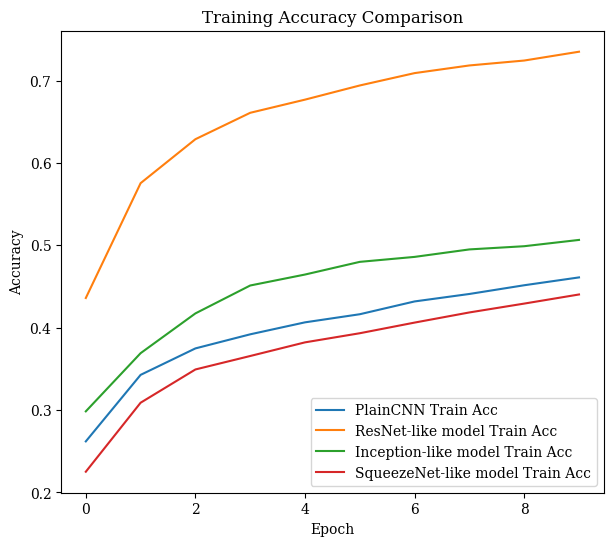

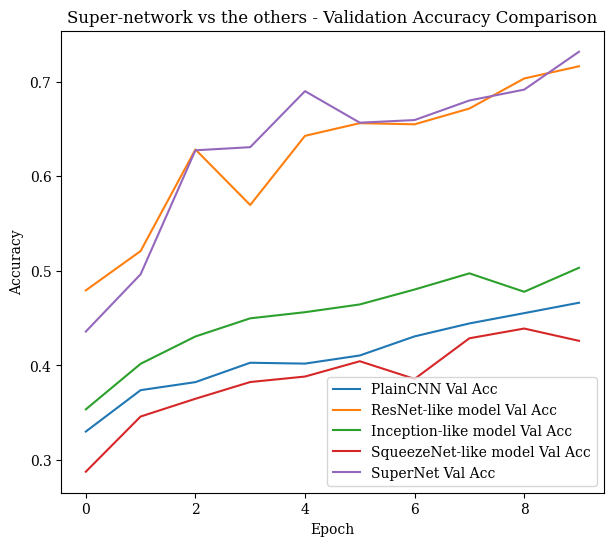

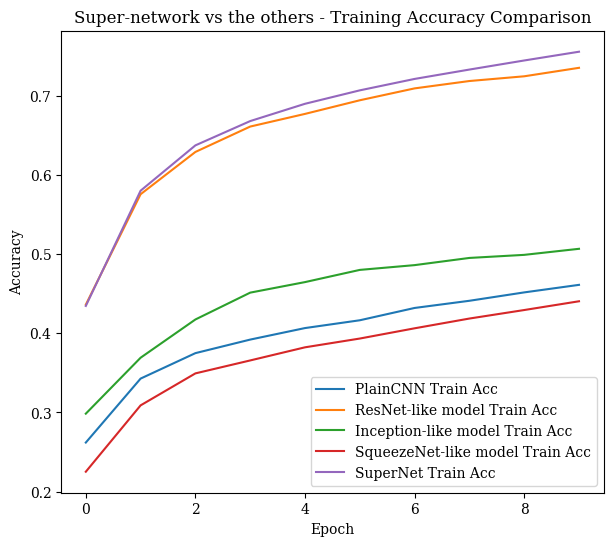

In [9]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,          # crucial
    "font.family": "serif",
    "mathtext.fontset": "cm",      # Computer Modern for math
    "font.serif": ["DejaVu Serif"] # will be used for normal text
})

# Plot comparison of all models
plt.figure(figsize=(7,6))
for name in results:
    if name == 'SuperNet':
        continue
    plt.plot(results[name]['val_acc'], label=f'{name} Val Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('validation_accuracy_comparison.png')
plt.show()

plt.figure(figsize=(7,6))
for name in results:
    if name == 'SuperNet':
        continue
    plt.plot(results[name]['train_acc'], label=f'{name} Train Acc')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_accuracy_comparison.png')
plt.show()

plt.figure(figsize=(7,6))
for name in results:
    plt.plot(results[name]['val_acc'], label=f'{name} Val Acc')
plt.title('Super-network vs the others - Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('supernet_vs_others_validation_accuracy.png')
plt.show()

plt.figure(figsize=(7,6))
for name in results:
    plt.plot(results[name]['train_acc'], label=f'{name} Train Acc')
plt.title('Super-network vs the others - Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('supernet_vs_others_training_accuracy.png')
plt.show()